# Mixture Density Network for Regression

In [1]:
import nbloader,os,warnings
warnings.filterwarnings("ignore") 
import numpy as np
import gym
import pickle
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf
import tensorflow.contrib.slim as slim
from sklearn.utils import shuffle
from util import gpusession,create_gradient_clipping,data4imitation_noisy,data4imitation_expert_crazy,plot_1dRegData,print_n_txt
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'
if __name__ == "__main__":
    print ("TensorFlow version is [%s]."%(tf.__version__))

TensorFlow version is [1.10.0].


### Define MDN Class

In [2]:
class mdn_imitation_class(object):
    def __init__(self,_name='MDN',_envname='HalfCheetah-v2',_xdim=1,_ydim=1,_hdims=[64,64],_sigmax=0
                 ,_kmix=5,_actv=tf.nn.relu,_bn=slim.batch_norm
                 ,_l2_reg_coef=1e-5,_GPU_ID=0,_VERBOSE=True):
        self.name = _name
        self.envname = _envname
        self.env = gym.make(_envname)
        self.xdim = _xdim
        self.ydim = _ydim
        self.hdims = _hdims
        self.sigmax = _sigmax
        self.kmix = _kmix
        self.actv = _actv 
        self.bn   = _bn # slim.batch_norm / None
        self.l2_reg_coef = _l2_reg_coef # L2 regularizer 
        self.GPU_ID = _GPU_ID
        self.VERBOSE = _VERBOSE
#         with tf.device('/device:CPU:%d'%(self.GPU_ID)):
        # Build model
        self.build_model()
        # Build graph
        self.build_graph()
        # Check parameters
        self.check_params()
        
    def build_model(self):
        self.x = tf.placeholder(dtype=tf.float32,shape=[None,self.xdim]) # Input [N x xdim]
        self.t = tf.placeholder(dtype=tf.float32,shape=[None,self.ydim]) # Output [N x ydim]
        self.kp = tf.placeholder(dtype=tf.float32,shape=[]) # Keep probability 
        self.lr = tf.placeholder(dtype=tf.float32,shape=[]) # Learning rate
        self.is_training = tf.placeholder(dtype=tf.bool,shape=[]) # Training flag
        # Initializers
        self.fully_init  = tf.random_normal_initializer(stddev=0.01)
        self.bias_init   = tf.constant_initializer(0.)
        self.bn_init     = {'beta': tf.constant_initializer(0.),
                           'gamma': tf.random_normal_initializer(1., 0.01)}
        self.bn_params   = {'is_training':self.is_training,'decay':0.9,'epsilon':1e-5,
                           'param_initializers':self.bn_init,'updates_collections':None}
        # Build graph
        with tf.variable_scope(self.name,reuse=False) as scope:
            with slim.arg_scope([slim.fully_connected],activation_fn=self.actv,
                                weights_initializer=self.fully_init,biases_initializer=self.bias_init,
                                normalizer_fn=self.bn,normalizer_params=self.bn_params,
                                weights_regularizer=None):
                _net = self.x
                for h_idx in range(len(self.hdims)): # Loop over hidden layers
                    _hdim = self.hdims[h_idx]
                    _net = slim.fully_connected(_net,_hdim,scope='lin'+str(h_idx))
                    _net = slim.dropout(_net,keep_prob=self.kp,is_training=self.is_training
                                        ,scope='dr'+str(h_idx))
                self.feat = _net # [N x Q]
                # Class allocation probability 
                self.pi_logits = slim.fully_connected(self.feat,self.kmix,scope='pi_logits')
                self.pi = tf.nn.softmax(self.pi_logits,dim=1)
                # means (data x dim x mixture)
                self._mu = slim.linear(self.feat,self.kmix*self.ydim,scope='mu_flatten'
                                      ,biases_initializer=tf.random_uniform_initializer(minval=-2,maxval=+2))
                self.mu = tf.reshape(self._mu,shape=[-1,self.ydim,self.kmix])
                # varainces (data x dim x mixture)
                self.sigma_logits = slim.fully_connected(self.feat,self.kmix*self.ydim,scope='sigma_logits')
                if self.sigmax == 0:
                    self._sigma =tf.exp(self.sigma_logits)
                else:
                    self._sigma = self.sigmax*tf.nn.sigmoid(self.sigma_logits)
                # _sigma = tf.exp(_sigma_logits)
                self.sigma = tf.reshape(self._sigma,shape=[-1,self.ydim,self.kmix]) # [N x D x K]
                
    def build_graph(self):
        y = self.t
        pi = self.pi
        mu = self.mu
        sigma = self.sigma
        yrepeat = tf.tile(y[:,:,tf.newaxis],[1,1,self.kmix]) # (N x D x K)
        self.quadratics = -0.5*tf.reduce_sum(((yrepeat-mu)/sigma)**2,axis=1) # (N x K)
        self.logdet = -0.5*tf.reduce_sum(tf.log(sigma),axis=1) # (N x K)
        self.logconstant = - 0.5*self.ydim*tf.log(2*np.pi) # (1)
        self.logpi = tf.log(pi) # (N x K)
        self.exponents = self.quadratics + self.logdet + self.logconstant + self.logpi
        self.logprobs = tf.reduce_logsumexp(self.exponents,axis=1) # (N)
        self.gmm_prob = tf.exp(self.logprobs) # (N)
        self.gmm_nll  = -tf.reduce_mean(self.logprobs) # (1)
        # Weight decay 
        # _g_vars = tf.global_variables()
        _g_vars = tf.trainable_variables()
        self.c_vars = [var for var in _g_vars if '%s/'%(self.name) in var.name]
        self.l2_reg = self.l2_reg_coef*tf.reduce_sum(tf.stack([tf.nn.l2_loss(v) for v in self.c_vars])) # [1]
        # Loss and optimizer 
        self.loss_total = self.gmm_nll + self.l2_reg
        USE_ADAM = False
        if USE_ADAM:
            self.optm = tf.train.AdamOptimizer(learning_rate=self.lr
                , beta1=0.9, beta2=0.999, epsilon=1e-0).minimize(self.loss_total)
        else:
            self.optm = tf.train.MomentumOptimizer(learning_rate=self.lr
                                                   ,momentum=0.0).minimize(self.loss_total)
        # Compute regression loss 
        _N = tf.shape(self.x)[0] # Number of data
        maxIdx = tf.argmax(input=pi,axis=1, output_type=tf.int32) # Argmax Index [N]
        # maxIdx = 0*tf.ones_like(maxIdx) # <== ???
        coords = tf.stack([tf.transpose(gv) for gv in tf.meshgrid(tf.range(_N),tf.range(self.ydim))] + 
                          [tf.reshape(tf.tile(maxIdx[:,tf.newaxis],[1,self.ydim]),shape=(_N,self.ydim))]
                          ,axis=2) # [N x D x 3]
        self.mu_bar = tf.gather_nd(mu,coords) # [N x D]
        self.fit_mse = tf.reduce_sum(tf.pow(self.mu_bar-self.t, 2))/(tf.cast(_N,tf.float32)) # Fitting error (mse)
        
    # Check parameters
    def check_params(self):
        _g_vars = tf.global_variables()
        self.g_vars = [var for var in _g_vars if '%s/'%(self.name) in var.name]
        if self.VERBOSE:
            print ("==== Global Variables ====")
        for i in range(len(self.g_vars)):
            w_name  = self.g_vars[i].name
            w_shape = self.g_vars[i].get_shape().as_list()
            if self.VERBOSE:
                print (" [%02d] Name:[%s] Shape:[%s]" % (i,w_name,w_shape))
    
    # Sampler
    def sampler(self,_sess,_x,n_samples=10,_USE_ARGMAX=True,_MU_ONLY=False):
        pi, mu, sigma = _sess.run([self.pi, self.mu, self.sigma],
                                  feed_dict={self.x:_x,self.kp:1.0,self.is_training:False})
        n_points = _x.shape[0]
        _y_sampled = np.zeros([n_points,self.ydim,n_samples])
        for i in range(n_points):
            for j in range(n_samples):
                if _USE_ARGMAX: # Use the most likely mixture
                    k = np.argmax(pi[i,:])
                else:
                    k = np.random.choice(self.kmix,p=pi[i,:])
                if _MU_ONLY: # Plot mu only
                    _y_sampled[i,:,j] = mu[i,:,k]
                else: # Sample from Gaussian
                    _y_sampled[i,:,j] = mu[i,:,k] + np.random.randn(1,self.ydim)*np.sqrt(sigma[i,:,k])
        return _y_sampled
    
    # Save 
    def save(self,_sess,_savename=None):
        """ Save name """
        if _savename==None:
            _savename='../net/net_%s.npz'%(self.name)
        """ Get global variables """
        self.g_wnames,self.g_wvals,self.g_wshapes = [],[],[]
        for i in range(len(self.g_vars)):
            curr_wname = self.g_vars[i].name
            curr_wvar  = [v for v in tf.global_variables() if v.name==curr_wname][0]
            curr_wval  = _sess.run(curr_wvar)
            curr_wval_sqz  = curr_wval.squeeze()
            self.g_wnames.append(curr_wname)
            self.g_wvals.append(curr_wval_sqz)
            self.g_wshapes.append(curr_wval.shape)
        """ Save """
        np.savez(_savename,g_wnames=self.g_wnames,g_wvals=self.g_wvals,g_wshapes=self.g_wshapes)
        if self.VERBOSE:
            print ("[%s] Saved. Size is [%.4f]MB" % 
                   (_savename,os.path.getsize(_savename)/1000./1000.))
            
    # Save 
    def save_final(self,_sess,_savename=None):
        """ Save name """
        if _savename==None:
            _savename='../net/net_%s_final.npz'%(self.name)
        """ Get global variables """
        self.g_wnames,self.g_wvals,self.g_wshapes = [],[],[]
        for i in range(len(self.g_vars)):
            curr_wname = self.g_vars[i].name
            curr_wvar  = [v for v in tf.global_variables() if v.name==curr_wname][0]
            curr_wval  = _sess.run(curr_wvar)
            curr_wval_sqz  = curr_wval.squeeze()
            self.g_wnames.append(curr_wname)
            self.g_wvals.append(curr_wval_sqz)
            self.g_wshapes.append(curr_wval.shape)
        """ Save """
        np.savez(_savename,g_wnames=self.g_wnames,g_wvals=self.g_wvals,g_wshapes=self.g_wshapes)
        print ("[%s] Saved. Size is [%.4f]MB" % 
               (_savename,os.path.getsize(_savename)/1000./1000.))
        
    # Restore
    def restore(self,_sess,_loadname=None):
        if _loadname==None:
            _loadname='../net/net_%s_final.npz'%(self.name)
        l = np.load(_loadname)
        g_wnames = l['g_wnames']
        g_wvals  = l['g_wvals']
        g_wshapes = l['g_wshapes']
        for widx,wname in enumerate(g_wnames):
            curr_wvar  = [v for v in tf.global_variables() if v.name==wname][0]
            _sess.run(tf.assign(curr_wvar,g_wvals[widx].reshape(g_wshapes[widx])))
        if self.VERBOSE:
            print ("Weight restored from [%s] Size is [%.4f]MB" % 
                   (_loadname,os.path.getsize(_loadname)/1000./1000.))
    
    # Save to mat file
    def save2mat(self,_xdata='',_ydata='',_yref=''):
        # Save weights to mat file so that MATLAB can use it.
        npzPath = '../net/net_%s.npz'%(self.name)
        l = np.load(npzPath)
        g_wnames = l['g_wnames']
        g_wvals  = l['g_wvals']
        g_wshapes = l['g_wshapes']
        D = {}
        for widx,wname in enumerate(g_wnames):
            cName = wname.replace(':0','')
            cName = cName.replace(self.name+'/','')
            cName = cName.replace('/','_')
            cVal = g_wvals[widx].reshape(g_wshapes[widx])
            D[cName] = cVal
            # Do not print out..
            # if self.VERBOSE: print ("name is [%s] shape is %s."%(cName,cVal.shape,))
        # Save data
        if _xdata!='': D['xdata']=_xdata
        if _ydata!='': D['ydata']=_ydata
        if _yref!='': D['yref']=_yref
        # Save dictionary D to the mat file
        matPath = '../data/net_%s.mat'%(self.name)
        sio.savemat(matPath,D)
        if self.VERBOSE: print ("[%s] saved."%(matPath))
        
    # Save to mat file
    def save2mat_final(self,_xdata='',_ydata='',_yref=''):
        # Save weights to mat file so that MATLAB can use it.
        npzPath = '../net/net_%s_final.npz'%(self.name)
        l = np.load(npzPath)
        g_wnames = l['g_wnames']
        g_wvals  = l['g_wvals']
        g_wshapes = l['g_wshapes']
        D = {}
        for widx,wname in enumerate(g_wnames):
            cName = wname.replace(':0','')
            cName = cName.replace(self.name+'/','')
            cName = cName.replace('/','_')
            cVal = g_wvals[widx].reshape(g_wshapes[widx])
            D[cName] = cVal
            if self.VERBOSE: print ("name is [%s] shape is %s."%(cName,cVal.shape,))
        # Save data
        if _xdata!='': D['xdata']=_xdata
        if _ydata!='': D['ydata']=_ydata
        if _yref!='': D['yref']=_yref
        # Save dictionary D to the mat file
        matPath = '../data/net_%s_final.mat'%(self.name)
        sio.savemat(matPath,D)
        print ("[%s] Saved. Size is [%.4f]MB" % 
               (matPath,os.path.getsize(matPath)/1000./1000.))
        
    # Train
    def train(self,_sess,_x,_y,_yref='',_lr=1e-3,_batchSize=512,_maxEpoch=1e4,_kp=1.0
              ,_LR_SCHEDULE=True
              ,_PRINT_EVERY=20,_PLOT_EVERY=20
              ,_SAVE_TXT=True,_SAVE_BEST_NET=True,_SAVE_FINAL=True):
        
        # Reference training data 
        _x_train,_y_train = _x,_y
        
        # Iterate
        if _PRINT_EVERY == 0: print_period = 0
        else: print_period = _maxEpoch//_PRINT_EVERY
        if _PLOT_EVERY == 0: plot_period = 0
        else: plot_period = _maxEpoch//_PLOT_EVERY
        
        maxIter = max(_x_train.shape[0]//_batchSize, 1)
        bestLossVal = np.inf
        if _SAVE_TXT:
            txtName = ('../res/imitation_%s.txt'%(self.name));f = open(txtName,'w') # Open txt file
            print_n_txt(_f=f,_chars='Text name: '+txtName,_DO_PRINT=True)
        for epoch in range((int)(_maxEpoch)+1): # For every epoch
            _x_train,_y_train = shuffle(_x_train,_y_train)
            for iter in range(maxIter): # For every iteration
                start,end = iter*_batchSize,(iter+1)*_batchSize
                if _LR_SCHEDULE:
                    if epoch < 0.5*_maxEpoch:
                        lr_use = _lr
                    elif epoch < 0.75*_maxEpoch:
                        lr_use = _lr/5.
                    else:
                        lr_use = _lr/10.
                else:
                    lr_use = _lr
                feeds = {self.x:_x_train[start:end,:],self.t:_y_train[start:end,:]
                         ,self.kp:_kp,self.lr:lr_use,self.is_training:True}
                # Optimize 
                _sess.run(self.optm,feeds)
            
            # Track the Best result
            BEST_FLAG = False
            check_period = _maxEpoch//100
            if (epoch%check_period)==0:
                feeds = {self.x:_x,self.t:_y,self.kp:1.0,self.is_training:False}
                opers = [self.loss_total,self.gmm_nll,self.l2_reg]
                lossVal,gmm_nll,l2_reg = _sess.run(opers,feeds)
                if (lossVal < bestLossVal) & (epoch >= 3):
                    bestLossVal = lossVal
                    BEST_FLAG = True
                    if _SAVE_BEST_NET:
                        self.save(_sess) # Save the current best model 
                        self.save2mat(_xdata=_x,_ydata=_y,_yref=_yref)
            
            # Print current result 
            if (print_period!=0) and ((epoch%print_period)==0 or (epoch==(_maxEpoch-1))): # Print 
                feeds = {self.x:_x,self.t:_y,self.kp:1.0,self.is_training:False}
                opers = [self.loss_total,self.gmm_nll,self.l2_reg]
                lossVal,gmm_nll,l2_reg = _sess.run(opers,feeds)
                if _SAVE_TXT:
                    strTemp = ("[%d/%d] loss:%.3f(gmm:%.3f+l2:%.3f) bestLoss:%.3f"
                               %(epoch,_maxEpoch,lossVal,gmm_nll,l2_reg,bestLossVal))
                    print_n_txt(_f=f,_chars=strTemp,_DO_PRINT=self.VERBOSE)
                else:
                    if self.VERBOSE:
                        print ("[%d/%d] loss:%.3f(gmm:%.3f+l2:%.3f) bestLoss:%.3f"
                                   %(epoch,_maxEpoch,lossVal,gmm_nll,l2_reg,bestLossVal))

            # Plot current result 
            if (plot_period!=0) and ((epoch%plot_period)==0 or (epoch==(_maxEpoch-1))): # Plot
                feeds = {self.x:_x,self.t:_y,self.kp:1.0,self.is_training:False}
                opers = [self.loss_total,self.gmm_nll,self.l2_reg]
                lossVal,gmm_nll,l2_reg = _sess.run(opers,feeds)
                 
                # Plot sampled outputs
                nSample = 3
                ytest = self.sampler(_sess=_sess,_x=_x,n_samples=nSample
                                     ,_USE_ARGMAX=False,_MU_ONLY=False)
                x_plot,y_plot = _x[:,0],_y[:,0] # Traning data 
                plt.figure(figsize=(8,4));
                plt.axis([np.min(x_plot),np.max(x_plot),np.min(y_plot)-0.1,np.max(y_plot)+0.1])
                if _yref != '': plt.plot(x_plot,_yref[:,0],'r.') # Plot reference
                plt.plot(x_plot,y_plot,'k.') # Plot training data
                for i in range(nSample): 
                    plt.plot(_x,ytest[:,0,i],'b.')
                plt.title("[%d/%d] name:[%s] lossVal:[%.3e]"%(epoch,_maxEpoch,self.name,lossVal))
                
                # Plot most-likely mean function
                ytest = self.sampler(_sess=_sess,_x=_x,n_samples=1
                                     ,_USE_ARGMAX=True,_MU_ONLY=True)
                x_plot,y_plot = _x[:,0],_y[:,0] # Traning data 
                plt.figure(figsize=(8,4));
                plt.axis([np.min(x_plot),np.max(x_plot),np.min(y_plot)-0.1,np.max(y_plot)+0.1])
                if _yref != '': plt.plot(x_plot,_yref[:,0],'r.') # Plot reference
                plt.plot(x_plot,y_plot,'k.') # Plot training data
                plt.plot(_x,ytest[:,0,0],'b-')
                plt.title("[%d/%d] name:[%s] lossVal:[%.3e]"%(epoch,_maxEpoch,self.name,lossVal))
                plt.show()
                
        # Save fianl weights
        if _SAVE_FINAL:
            self.save_final(_sess)
            self.save2mat_final(_xdata=_x,_ydata=_y,_yref=_yref)
    
    
    def evaluate_episode(self, _sess, animate=False): # Run policy and collect (state, action, reward) pairs
        env = self.env
        obs = env.reset()
        observes, actions, rewards, infos = [], [], [], []
        done = False
        while not done:

            obs = obs.astype(np.float32).reshape((1, -1))
            observes.append(obs)

            action = self.sampler(_sess=_sess,_x=obs,n_samples=1).reshape((1,-1))
            actions.append(action)
            obs, reward, done, info = env.step(action)

            if not isinstance(reward, float):
                reward = np.asscalar(reward)
            rewards.append(reward)
            infos.append(info)
        
        return (np.concatenate(observes), np.array(actions), np.array(rewards, dtype=np.float32), infos)

    def evaluate_policy(self, _sess, episodes): # collect trajectories
        total_steps = 0
        trajectories = []
        for e in range(episodes):
            observes, actions, rewards, infos = self.evaluate_episode(_sess)
            total_steps += observes.shape[0]
            trajectory = {'observes': observes,
                          'actions': actions,
                          'rewards': rewards,
                          'infos': infos}
            trajectories.append(trajectory)
        return trajectories
    
    # Test
    def test(self,_sess,_PLOT_TRAIN=True,_PLOT_RES=True,_SAVE_FIG=False):
        
        demonstrations = self.evaluate_policy(_sess, 100)
        avg_ret = np.mean([np.sum(d['rewards']) for d in demonstrations])
        std_ret = np.std([np.sum(d['rewards']) for d in demonstrations])
        print('Avg Return:%.02f (%.02f)'%(avg_ret,std_ret))
        with open('../res/%s.pickle'%(self.name),'wb') as f:
            pickle.dump({'avg_ret':avg_ret,'std_ret':std_ret},f)
            f.close()
        return avg_ret
    
if __name__ == "__main__":
    print ("mdn_reg_class defined.")

mdn_reg_class defined.


### Train MDN for Regression

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Instructions for updating:
dim is deprecated, use axis instead
Text name: ../res/imitation_MDN_HalfCheetah_E100_C00_var1.0e-06.txt


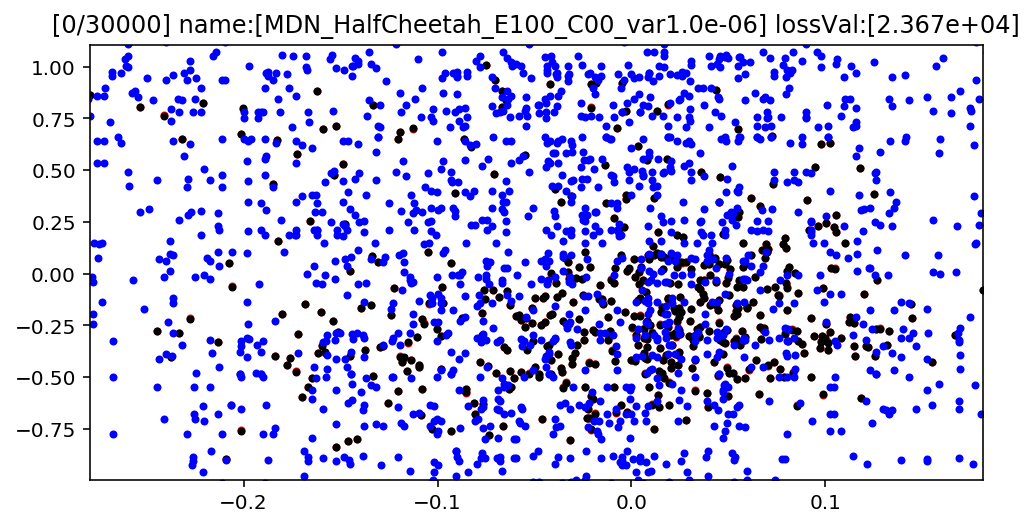

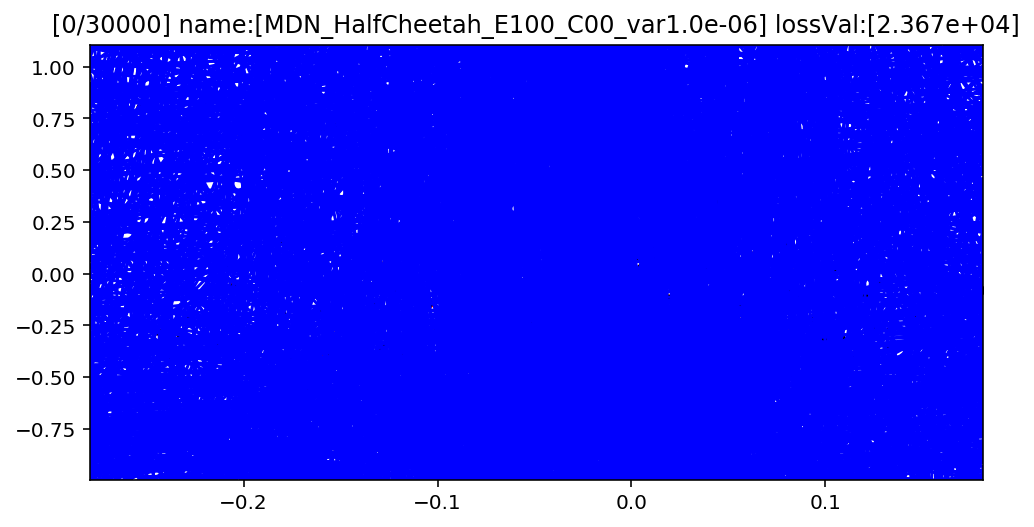

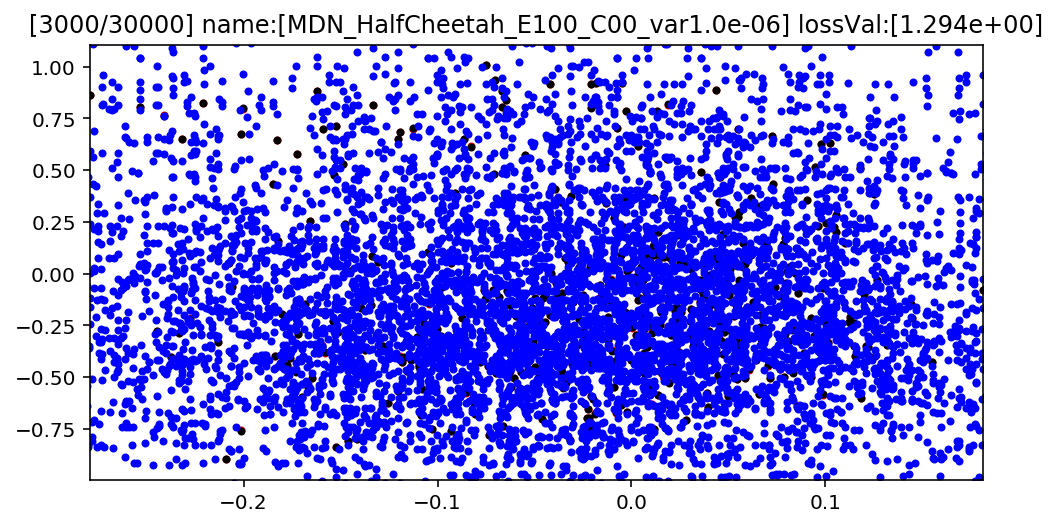

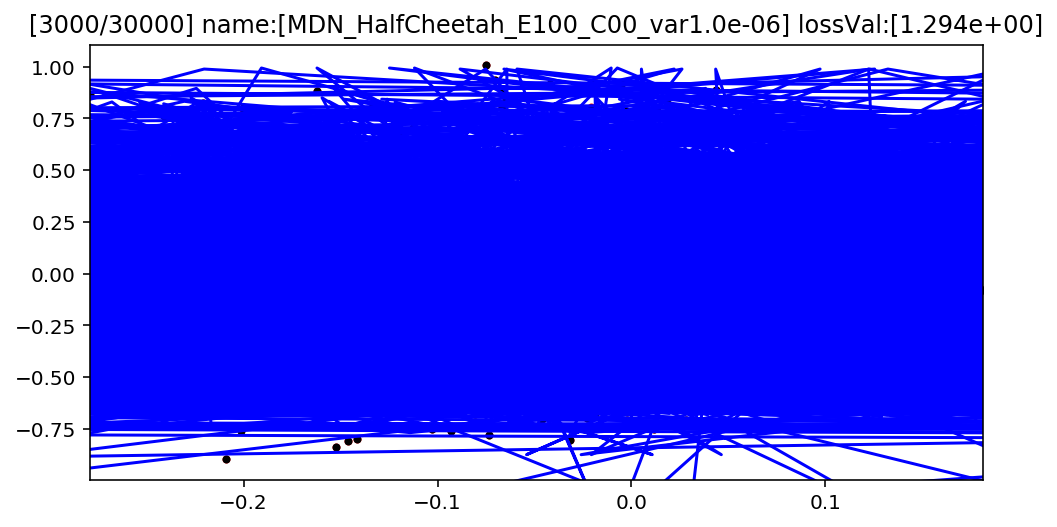

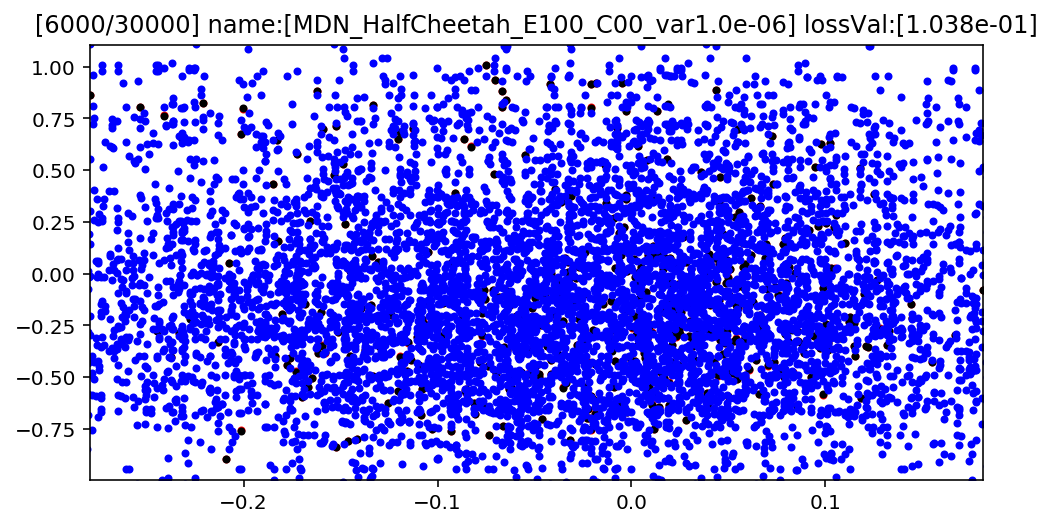

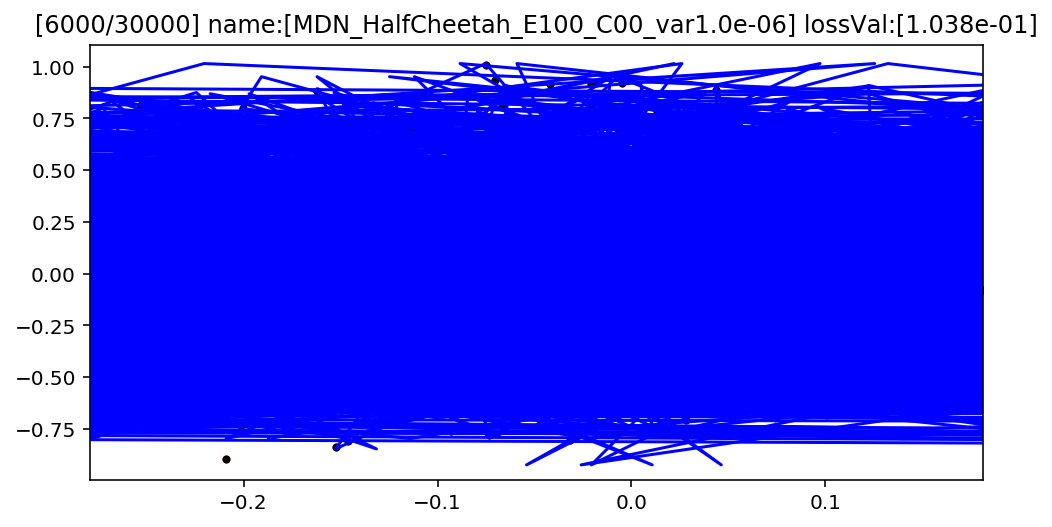

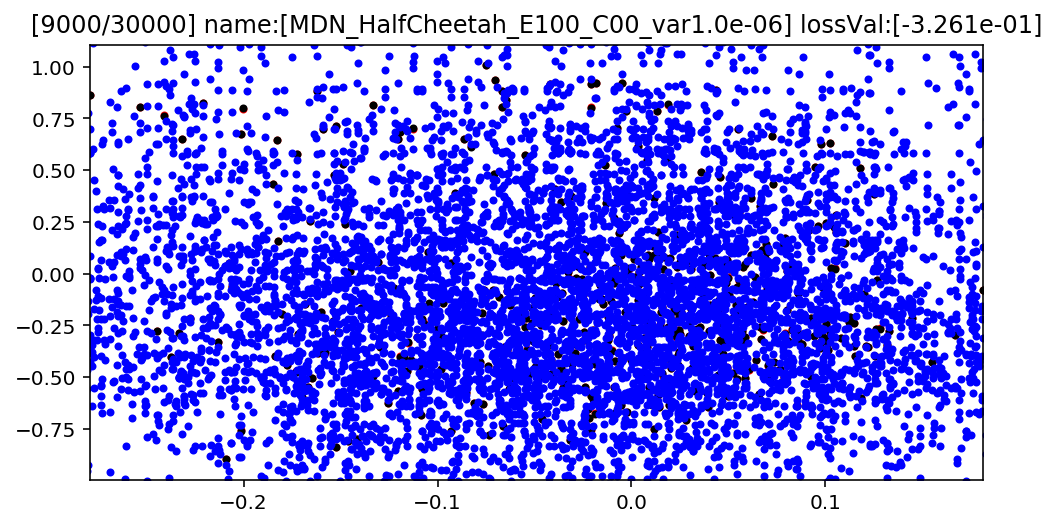

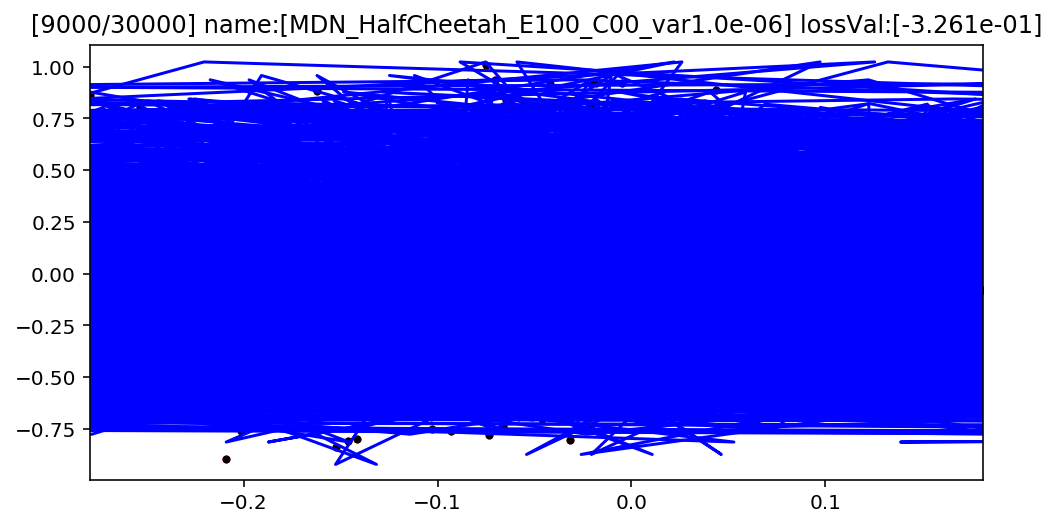

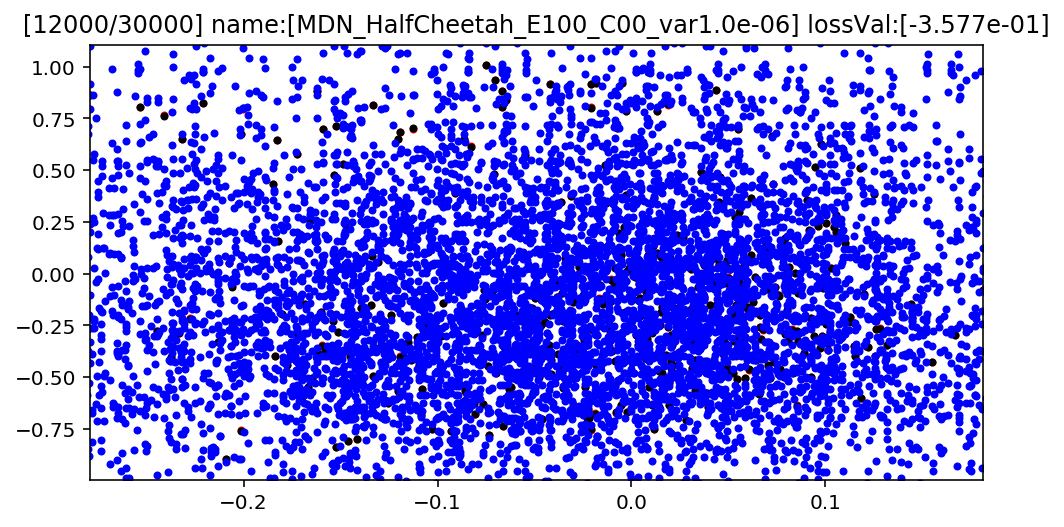

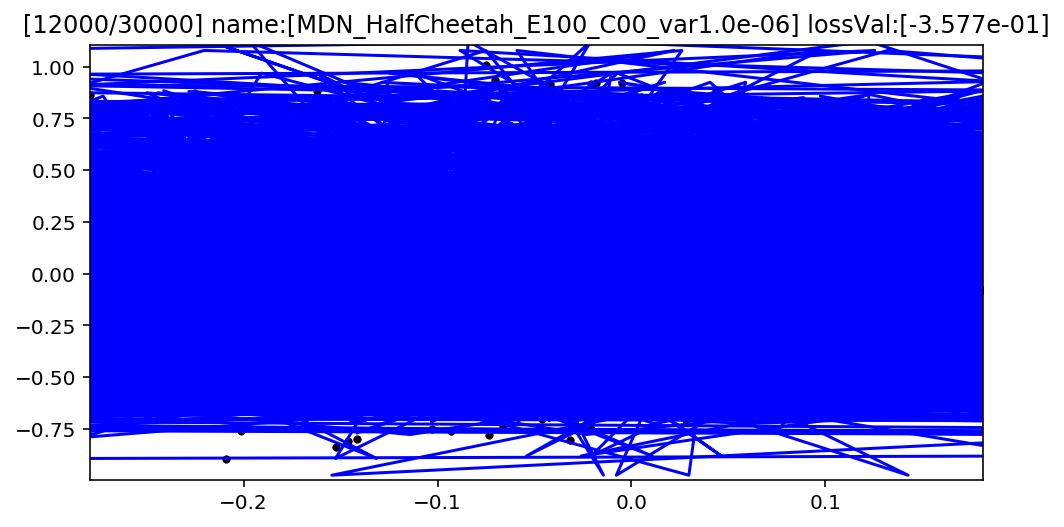

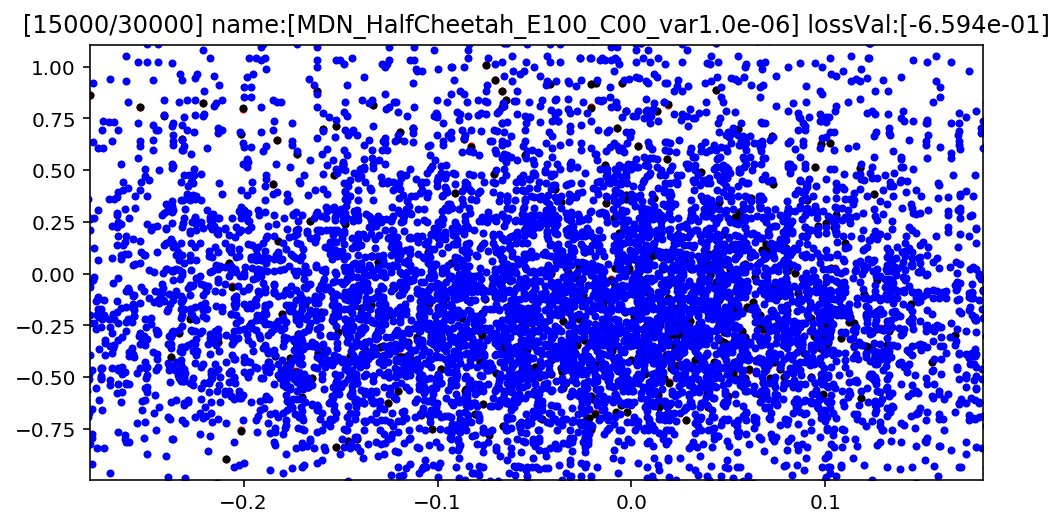

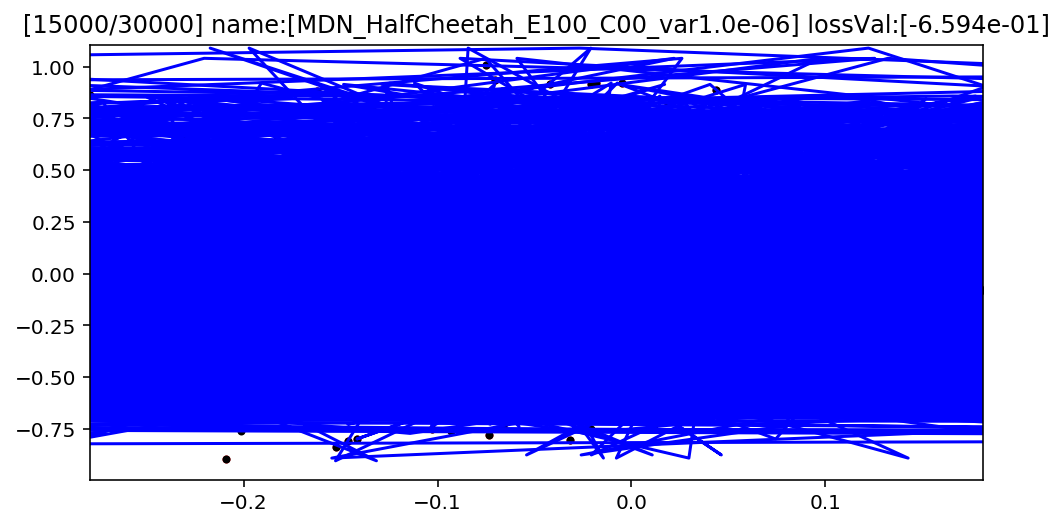

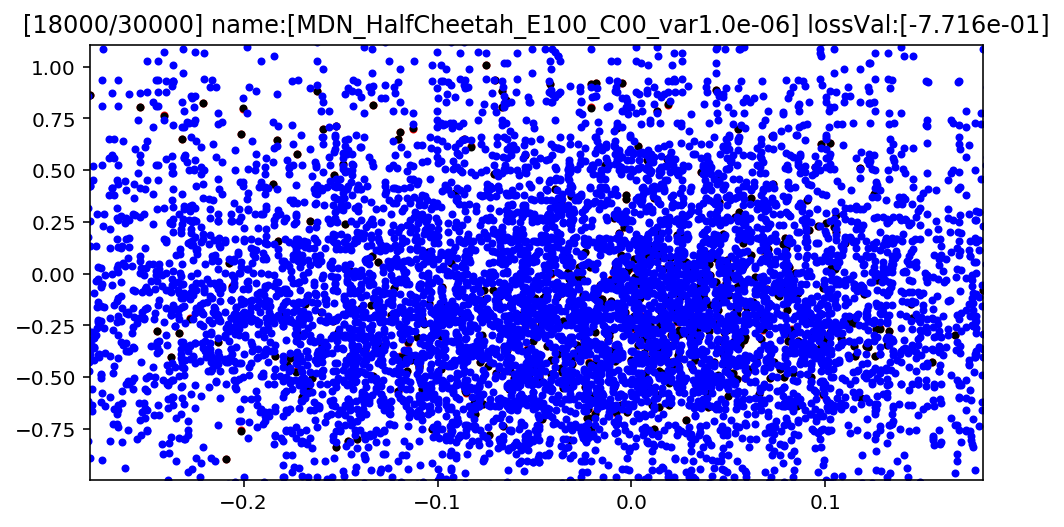

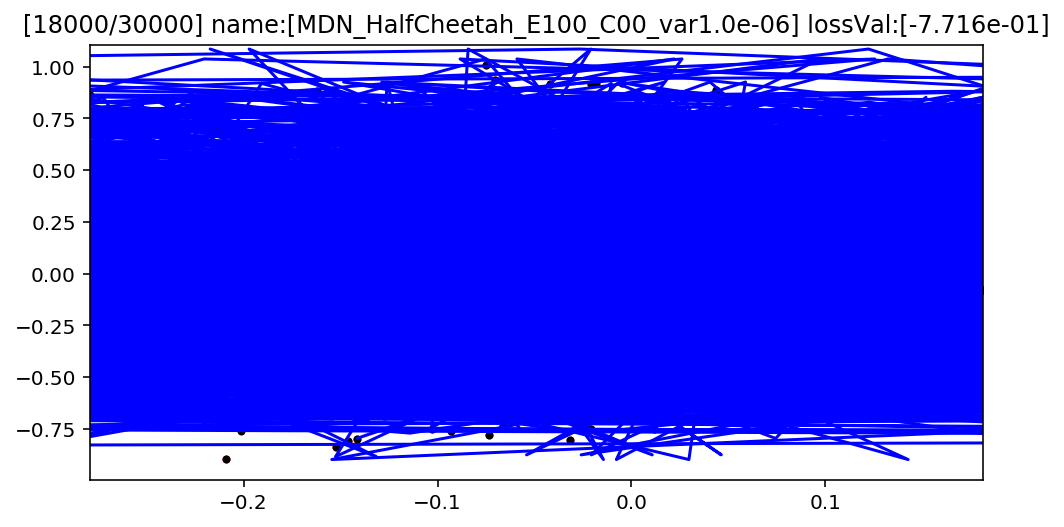

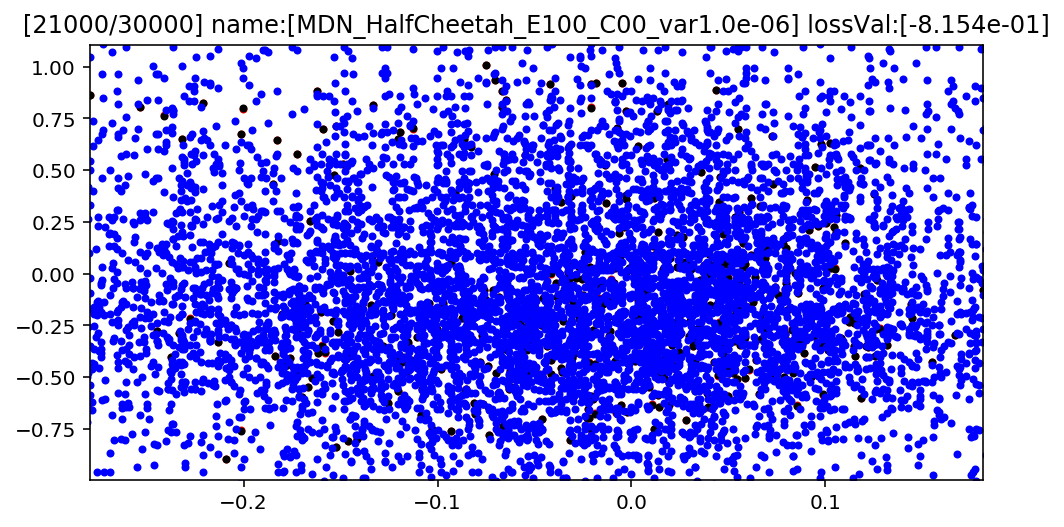

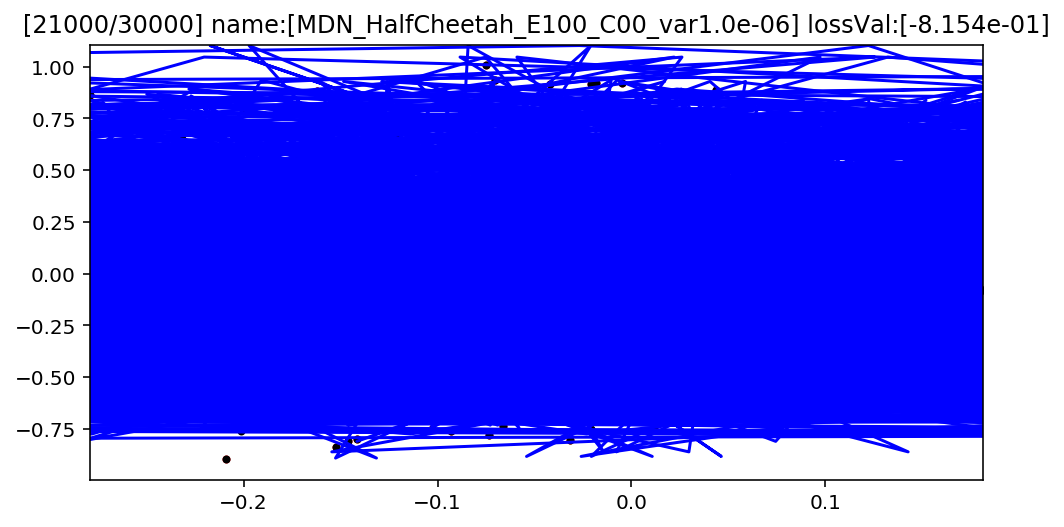

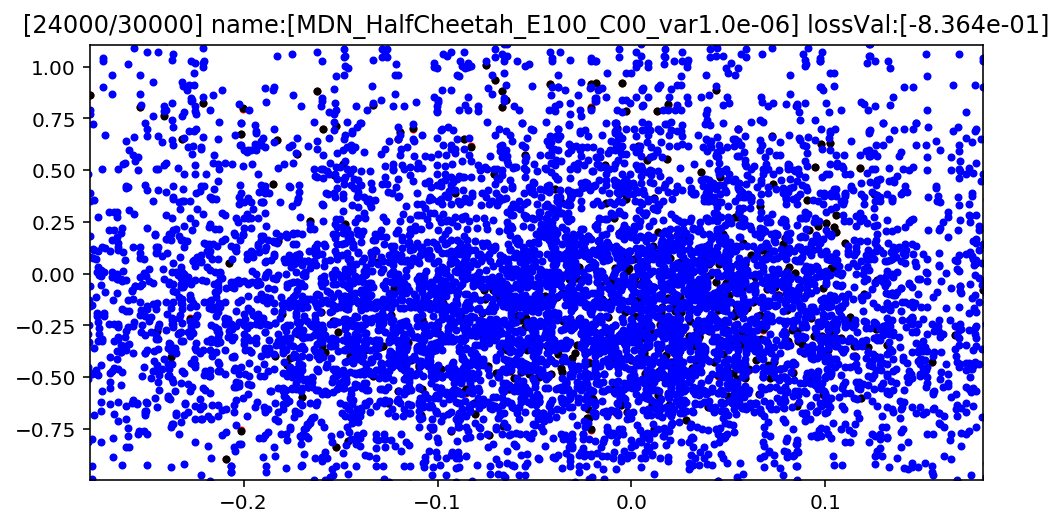

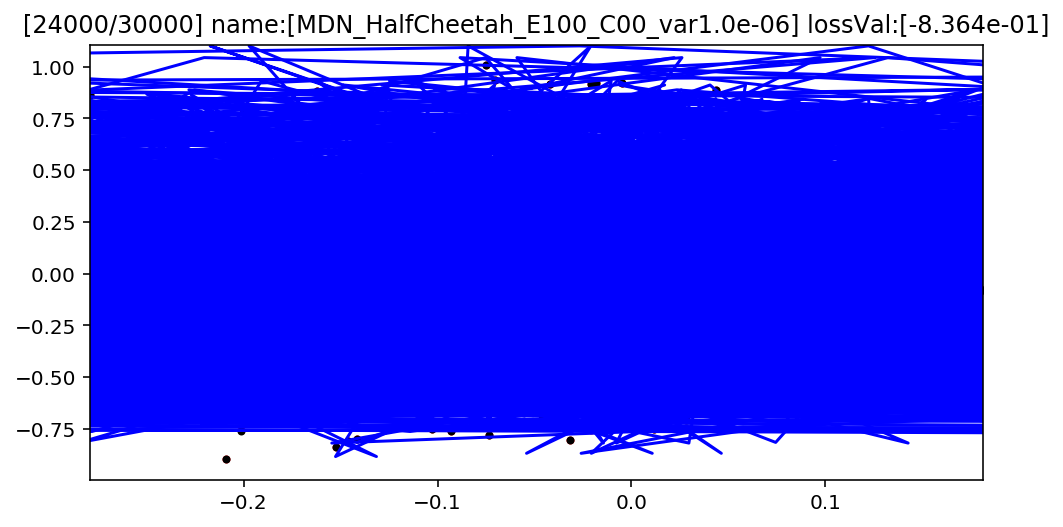

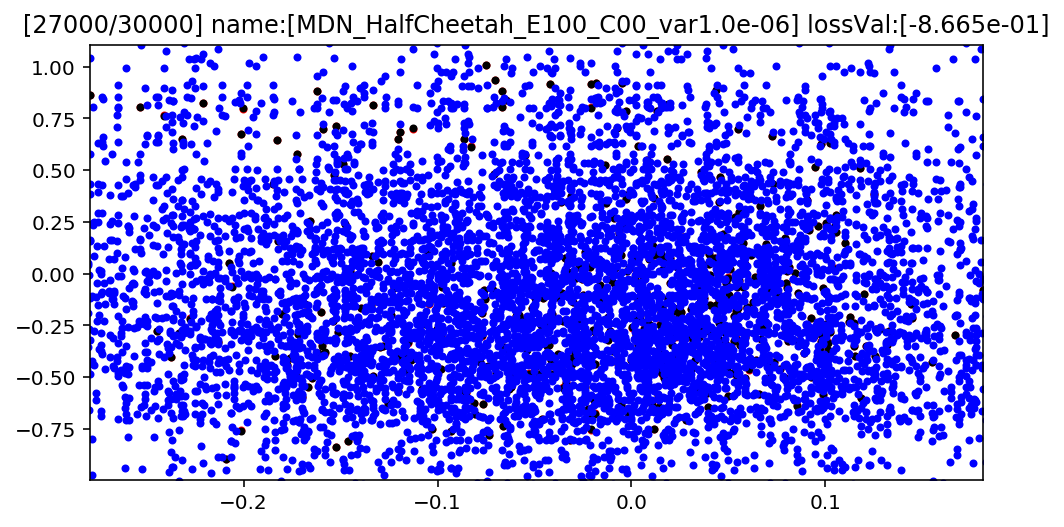

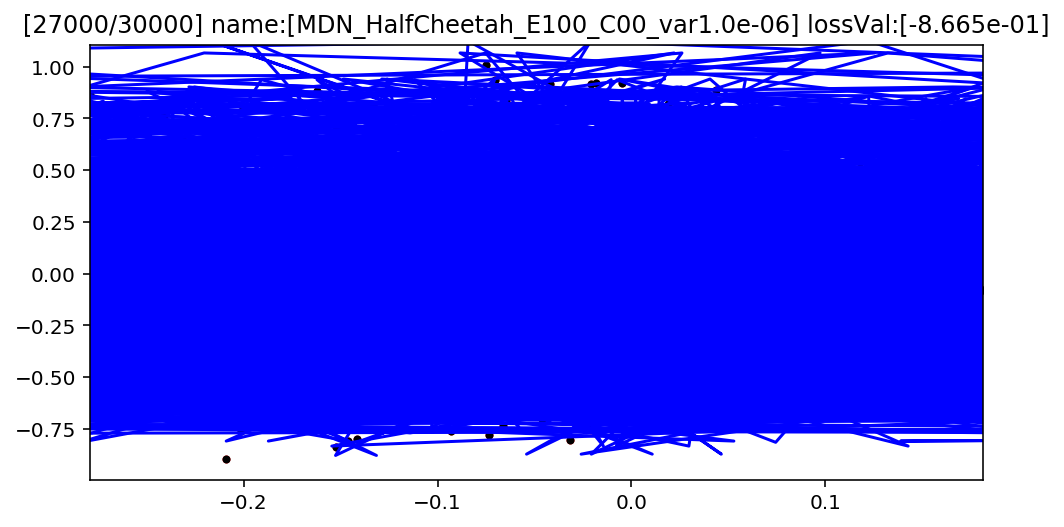

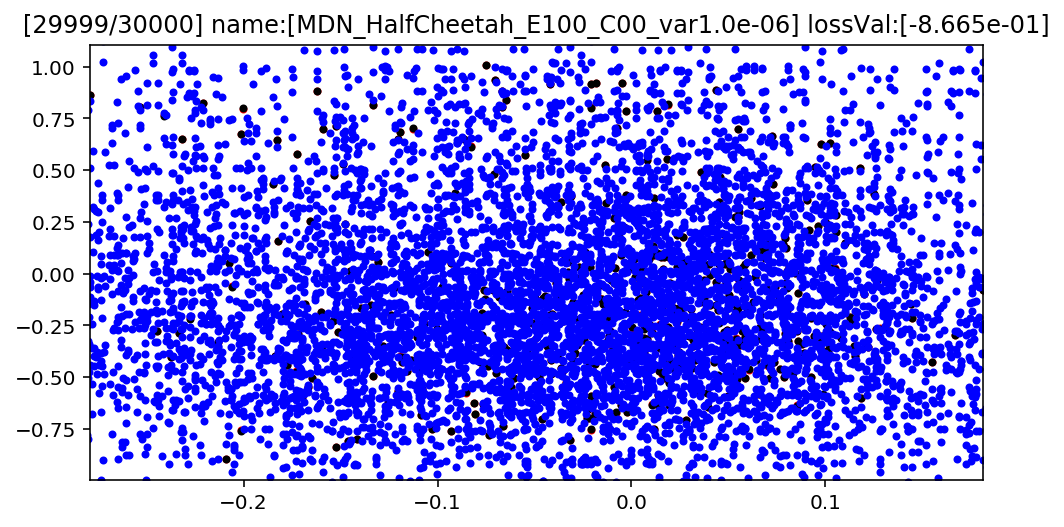

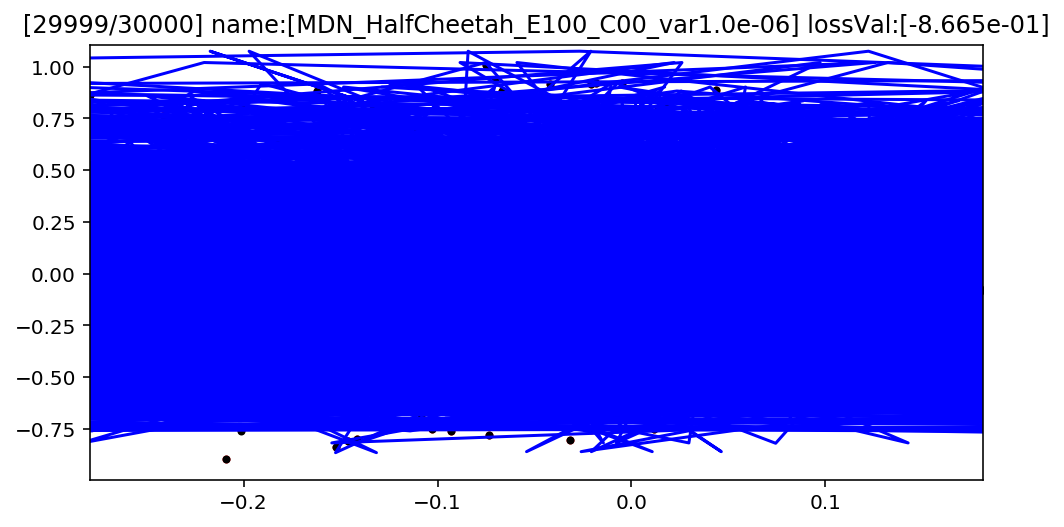

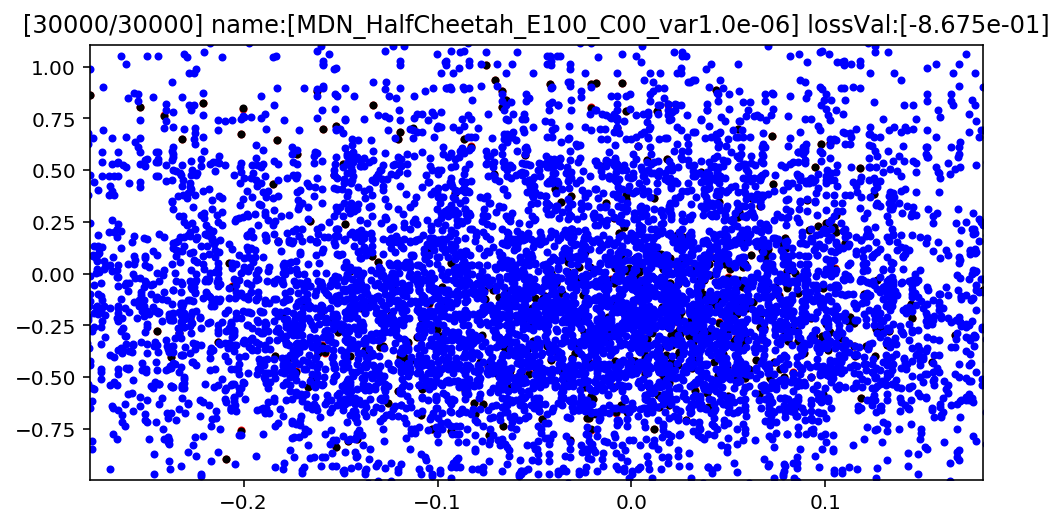

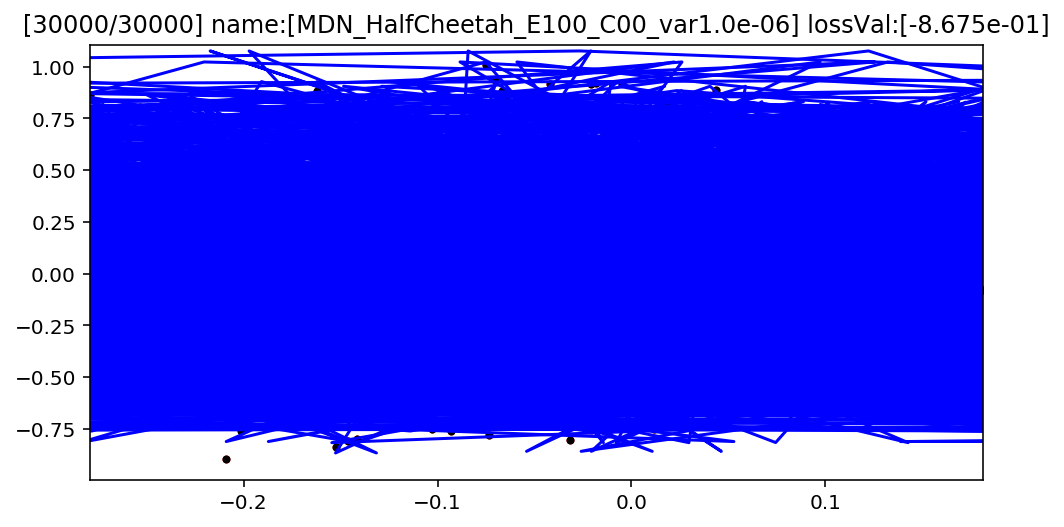

[../net/net_MDN_HalfCheetah_E100_C00_var1.0e-06_final.npz] Saved. Size is [0.0482]MB
[../data/net_MDN_HalfCheetah_E100_C00_var1.0e-06_final.mat] Saved. Size is [0.0971]MB
Train done.
Avg Return:871.35 (699.07)


In [3]:
if __name__ == "__main__":
    # Training data
    oRate = [1.0,0.0]
    measVar = 1e-6
    x,y,t=data4imitation_expert_crazy(envname="HalfCheetah-v2",_n=500,_oRate=oRate,measVar=measVar)
    
    # Make graph
    tf.reset_default_graph(); sess = gpusession()
    tf.set_random_seed(0); np.random.seed(0)        
    MDN =  mdn_imitation_class(_name='MDN_%s_E%02d_C%02d_var%.1e'%('HalfCheetah',oRate[0]*100,oRate[1]*100,measVar)
                         ,_xdim=x.shape[1],_ydim=y.shape[1],_hdims=[32,32],_sigmax=0.1
                         ,_kmix=3,_actv=tf.nn.relu,_bn=slim.batch_norm
                         ,_l2_reg_coef=1e-8,_GPU_ID=0,_VERBOSE=False)
    sess.run(tf.global_variables_initializer()) # Initialize variables
    
    # Train 
    DO_TRAIN = True 
    if DO_TRAIN:
        MDN.train(_sess=sess,_x=x,_y=y,_yref=t 
               ,_lr=1e-3,_batchSize=128,_maxEpoch=3e4,_kp=1.0
               ,_LR_SCHEDULE=True
               ,_PRINT_EVERY=10,_PLOT_EVERY=10
               ,_SAVE_TXT=True,_SAVE_BEST_NET=True)
        print ("Train done.") 
    else: 
        MDN.restore(sess)
        print ("Network restored.")
        
    # Test 
    avg_ret=MDN.test(_sess=sess)